In [1]:
import pandas as pd
import numpy as np
import finterstellar as fs

In [2]:
path = './data/'
cd = 'S&P 500'

In [3]:
file_name = path + cd + ' Historical Data.csv'
df = pd.read_csv(file_name, index_col='Date')
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
"Apr 15, 2019","2,905.58","2,908.32","2,909.60","2,896.48",-,-0.06%
"Apr 12, 2019","2,907.41","2,900.86","2,910.54","2,898.37",-,0.66%
"Apr 11, 2019","2,888.32","2,891.92","2,893.42","2,881.99",-,0.00%
"Apr 10, 2019","2,888.21","2,881.37","2,889.71","2,879.13",-,0.35%
"Apr 09, 2019","2,878.20","2,886.58","2,886.88","2,873.33",-,-0.61%


In [4]:
# 날짜 처리
ld = fs.LoadData()
df = ld.date_formatting(df)    
# date_formatting(데이터프레임) - 날짜 처리
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-04-15,"2,905.58","2,908.32","2,909.60","2,896.48",-,-0.06%
2019-04-12,"2,907.41","2,900.86","2,910.54","2,898.37",-,0.66%
2019-04-11,"2,888.32","2,891.92","2,893.42","2,881.99",-,0.00%
2019-04-10,"2,888.21","2,881.37","2,889.71","2,879.13",-,0.35%
2019-04-09,"2,878.20","2,886.58","2,886.88","2,873.33",-,-0.61%


In [5]:
df = ld.price_df_trimming(df, cd)
# price_df_trimming(데이터프레임) - 시세 처리
df.head()

,S&P 500
Date,
2017-01-03,2257.83
2017-01-04,2270.75
2017-01-05,2269.00
2017-01-06,2276.98
2017-01-09,2268.90


볼린저 밴드 계산

In [6]:
n = 20     # 평균주가계산 기준일수
sigma = 2     # 편차구간 지정 (시그마의 배수로)

In [7]:
df['center'] = df[cd].rolling(n).mean()
# 데이터프레임[데이터].rolling(기준일자).mean() - 이동평균 계산
df['ub'] = df['center'] + sigma * df[cd].rolling(n).std()
# 데이터프레임[데이터].rolling(기준일자).std() - 이동표준편차 계산
df['lb'] = df['center'] - sigma * df[cd].rolling(n).std()
df.tail()

,S&P 500,center,ub,lb
Date,,,,
2019-04-09,2878.20,2840.6585,2905.201318,2776.115682
2019-04-10,2888.21,2844.5230,2910.800744,2778.245256
2019-04-11,2888.32,2848.5150,2915.268073,2781.761927
2019-04-12,2907.41,2852.7615,2923.242576,2782.280424
2019-04-15,2905.58,2856.3935,2929.991395,2782.795605


In [8]:
base_date = '2018-01-01'    # 기준일자 설정

In [9]:
sample = df[base_date:].copy()    # 기준일 이후 데이터만 가져와 sample에 저장 (샘플링)
sample[15:25]

,S&P 500,center,ub,lb
Date,,,,
2018-01-24,2837.54,2754.9130,2864.626034,2645.199966
2018-01-25,2839.25,2762.8505,2872.865684,2652.835316
2018-01-26,2872.87,2772.3630,2886.009240,2658.716760
2018-01-29,2853.53,2780.6625,2892.455522,2668.869478
2018-01-30,2822.43,2788.1035,2889.193242,2687.013758
2018-01-31,2823.81,2794.5035,2886.817107,2702.189893
2018-02-01,2821.98,2799.9495,2884.562919,2715.336081
2018-02-02,2762.13,2801.8565,2880.790226,2722.922774
2018-02-05,2648.94,2797.1460,2898.804104,2695.487896


트레이드 북 생성

In [10]:
book = pd.DataFrame()    # 빈 트레이딩북(데이터프레임) 생성
book[cd] = sample[cd]    # sample에서 시세 복사
book['t '+cd] = ''     # 매매전략 입력을 위한 trade 컬럼 생성
book['p '+cd] = ''     # 포지션 입력을 위한 p 종목코드 컬럼 생성
book.head()

,S&P 500,t S&P 500,p S&P 500
Date,,,
2018-01-02,2695.81,,
2018-01-03,2713.06,,
2018-01-04,2723.99,,
2018-01-05,2743.15,,
2018-01-08,2747.71,,


트레이딩 전략 수립

In [11]:
thd = 'ub'   # 종목 매도 기준 (편차구간상단:ub, 편차구간중심:center)

In [12]:
# 백테스팅 매매전략 구현
'''
    sample.loc[i, cd] : i일의 가격
    sample.loc[i, center] : i일의 평균가격 (center)
    sample.loc[i, ub] : i일의 상단가격 (upper bound)
    sample.loc[i, lb] : i일의 하단가격 (lower bound)
'''
for i in sample.index:
    price = sample.loc[i, cd]
    if price > sample.loc[i, thd]:    # 가격 > thd :
        book.loc[i, 't '+cd] = ''   # trade : do nothing
    elif sample.loc[i, thd] >= price and price >= sample.loc[i, 'lb']:    #사이에서는
        if book.shift(1).loc[i, 't '+cd] == 'buy':    # 이미 매수상태라면
            book.loc[i, 't '+cd] = 'buy'     # 매수상태 유지
        else:
            book.loc[i, 't '+cd] = ''     # 빈손상태 유지
    elif sample.loc[i, 'lb'] > price:    # lb > 가격 :
        book.loc[i, 't '+cd] = 'buy'    # trade : buy (매수상태 유지)

In [13]:
book

,S&P 500,t S&P 500,p S&P 500
Date,,,
2018-01-02,2695.81,,
2018-01-03,2713.06,,
2018-01-04,2723.99,,
2018-01-05,2743.15,,
2018-01-08,2747.71,,
2018-01-09,2751.29,,
2018-01-10,2748.23,,
2018-01-11,2767.56,,
2018-01-12,2786.24,,


트레이딩 전략에 따른 포지션

In [14]:
status = ''
for i in book.index:
    if book.loc[i, 't '+cd] == 'buy':    # 매수 상태에서는
        if book.shift(1).loc[i, 't '+cd] == 'buy':    # 이미 매수 상태였다면
            status = 'll'     # 롱 유지
        elif book.shift(1).loc[i, 't '+cd] == '':     # zero 상태였다면
            status = 'zl'     # zero -> 롱
        else:
            status = 'zl'
    elif book.loc[i, 't '+cd] == '':
        if book.shift(1).loc[i, 't '+cd] == 'buy':
            status = 'lz'
        elif book.shift(1).loc[i, 't '+cd] == '':
            status = 'zz'
        else:
            status = 'zz'
    else:
        status = 'zz'
    book.loc[i, 'p '+cd] = status


In [15]:
book[20:25]

,S&P 500,t S&P 500,p S&P 500
Date,,,
2018-01-31,2823.81,,zz
2018-02-01,2821.98,,zz
2018-02-02,2762.13,,zz
2018-02-05,2648.94,buy,zl
2018-02-06,2695.14,buy,ll


In [16]:
rtn = 1.0
book['return'] = 1
buy = 0.0
sell = 0.0
for i in book.index:

    if book.loc[i, 'p '+cd] == 'zl' or book.loc[i, 'p '+cd] == 'sl' :     # long 진입
        buy = book.loc[i, cd]    # 매수 가격 확정
        print(i.date(), 'long '+cd, buy)
    elif book.loc[i, 'p '+cd] == 'lz' or book.loc[i, 'p '+cd] == 'ls' :     # long 청산
        sell = book.loc[i, cd]    # 매도 가격 확정
        # 손익 계산
        rtn = (sell - buy) / buy + 1    
        # 손익 = (매도가-매수가)/매수가 + 1 , 100원 투자해서 10원 벌면 손익은 1.10
        book.loc[i, 'return'] = rtn    # 트레이딩북에 손익 기록
        print(i.date(), 'long '+cd, buy, ' | unwind long '+cd, sell, ' | return:', round(rtn, 4))

    # 공매도가 허용되는 경우라면
    elif book.loc[i, 'p '+cd] == 'zs' or book.loc[i, 'p '+cd] == 'ls' :     # short 진입
        sell = book.loc[i, cd]    # 공매도 가격 확정
        print(i.date(), 'short '+cd, sell)
    elif book.loc[i, 'p '+cd] == 'sz' or book.loc[i, 'p '+cd] == 'sl' :     # short 청산
        buy = book.loc[i, cd]    # 숏커버 가격 확정
        # 손익 계산
        rtn = (sell - buy) / sell + 1
        book.loc[i, 'return'] = rtn
        print(i.date(), 'short '+cd, sell, ' | unwind short '+cd, buy, ' | return:', round(rtn, 4))

if book.loc[i, 't '+cd] == '' and book.loc[i, 'p '+cd] == '':     # zero position
    buy = 0.0
    sell = 0.0

acc_rtn = 1.0
for i in book.index:
    rtn = book.loc[i, 'return']
    acc_rtn = acc_rtn * rtn
    book.loc[i, 'acc return'] = acc_rtn

print ('Accunulated return :', round(acc_rtn, 4))

2018-02-05 long S&P 500 2648.94
2018-05-10 long S&P 500 2648.94  | unwind long S&P 500 2723.07  | return: 1.028
2018-06-27 long S&P 500 2699.63
2018-08-27 long S&P 500 2699.63  | unwind long S&P 500 2896.74  | return: 1.073
2018-10-10 long S&P 500 2785.68
2019-03-18 long S&P 500 2785.68  | unwind long S&P 500 2832.94  | return: 1.017
Accunulated return : 1.1218


In [17]:
# 벤치마크 수익률
bm_rtn = round (( book[cd].iloc[-1] - book[cd].iloc[0] ) / book[cd].iloc[0] + 1, 4)
print('BM return:', round(bm_rtn, 4) )

BM return: 1.0778


In [18]:
exs_rtn = ( round(acc_rtn/bm_rtn, 4) - 1 ) * 100
print('Excess return:', round(exs_rtn, 4) )

Excess return: 4.08


In [19]:
v = fs.Visualize()     # 그래프 모듈 준비

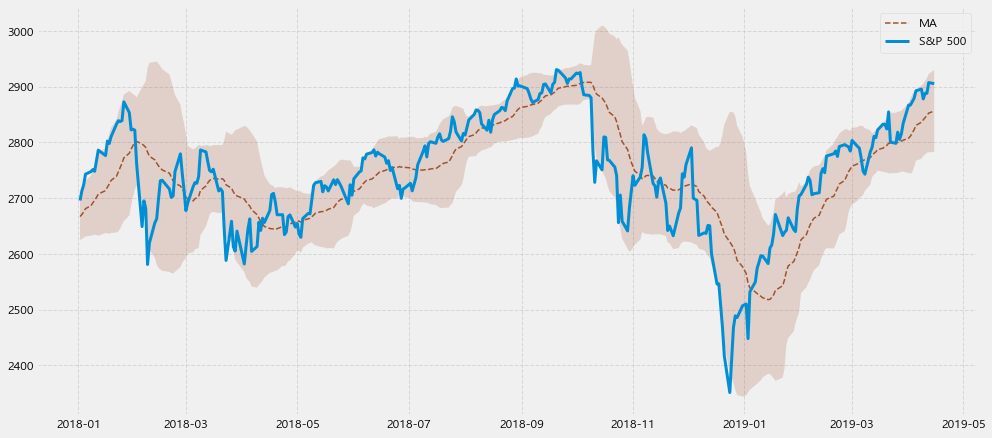

In [20]:
v.bb_trend_view(sample, cd)
# v 모듈의 bb_trend_view(데이터프레임, 편차구간, 종목코드, (사이즈)) 함수를 이용해 볼린저밴드 그래프 그리기

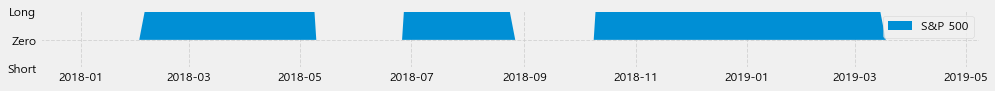

In [21]:
v.position_view(book, cd)
# v 모듈의 position_view(트레이딩북, 종목코드, (사이즈)) 함수를 이용해 포지션 보유내역 그래프 그리기